In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import tqdm
import numpy as np
import os

In [3]:
from datetime import datetime, timedelta
from tqdm.auto import tqdm

In [4]:
def find_yesterday(today,raw_df):
  yesterday = datetime.strptime(str(today), "%Y%m%d") - timedelta(days=1)
  yesterday = int(datetime.strftime(yesterday, "%Y%m%d"))
  while yesterday not in raw_df['날짜'].values:
      yesterday = datetime.strptime(str(yesterday), "%Y%m%d") - timedelta(days=1)
      yesterday = int(datetime.strftime(yesterday, "%Y%m%d"))
  return yesterday

def find_5_yesterdays(today,raw_df):
  yes1 = find_yesterday(today,raw_df)
  yes2 = find_yesterday(yes1,raw_df)
  yes3 = find_yesterday(yes2,raw_df)
  yes4 = find_yesterday(yes3,raw_df)
  yes5 = find_yesterday(yes4,raw_df)
  return [yes1,yes2,yes3,yes4,yes5]

In [25]:
# 날짜, 시간, 시가, 고가, 저가, 종가, 거래량, 거래대금, 누적체결매도수량, 누적체결매수수량
def CsvToData2(data_type, piece_length,looking_forward_length,threshold_ratio):
    file_path = '/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/{}'.format(data_type)
    labels = list()
    ret_data = list()

    for file_name in tqdm(os.listdir(file_path)):
        full_path = os.path.join(file_path, file_name)
        raw_df = pd.read_csv(full_path, encoding='euc-kr')
        transform1 = raw_df[raw_df['시간'] <= 1000]
        transform2 = (transform1.groupby(by='날짜').count()['시간'] == 60)
        filtered_date = transform2.index[transform2].values

        if len(filtered_date) == 0:
            continue
        #yesterday = filtered_date[0]
        for j, today in enumerate(filtered_date):
            if j in [0,1,2,3,4]:
              continue
            yesterdays=find_5_yesterdays(today,raw_df)
            yesterday=yesterdays[0]  
            today_df = raw_df[raw_df['날짜'] == today].iloc[:, 2:]
            today_start_price = today_df['시가'].values.tolist()[0]
            today_low_price = min(today_df['저가'].values.tolist())
            today_high_price = max(today_df['고가'].values.tolist())
            yesterday_end_price = raw_df[raw_df['날짜'] == yesterday].iloc[-1, 5]
            cond2 = (today_start_price >= (yesterday_end_price*1.00)) and (today_start_price < (yesterday_end_price * 1.10))
            cond3 = (today_low_price >= 300) and (today_high_price < 1000)
            cond4 = (today_low_price >= 3000) and (today_high_price < 10000)
            cond5 = (today_low_price >= 30000)
            if (cond3==0) and (cond4 == 0) and (cond5 == 0):
                continue
            if cond2 == 0:
                continue
            yesterday_df = raw_df[raw_df['날짜'] == yesterday]
            yesterday_df = yesterday_df[yesterday_df['시간']<=1000]
            yesterday_trade = yesterday_df['거래량'].sum()/60
            yesterday_df2 = raw_df[raw_df['날짜'] == yesterdays[1]]
            yesterday_df2 = yesterday_df2[yesterday_df2['시간']<=1000]
            yesterday_trade2 = yesterday_df2['거래량'].sum()/60
            yesterday_df3 = raw_df[raw_df['날짜'] == yesterdays[2]]
            yesterday_df3 = yesterday_df3[yesterday_df3['시간']<=1000]
            yesterday_trade3 = yesterday_df3['거래량'].sum()/60
            yesterday_df4 = raw_df[raw_df['날짜'] == yesterdays[3]]
            yesterday_df4 = yesterday_df4[yesterday_df4['시간']<=1000]
            yesterday_trade4 = yesterday_df4['거래량'].sum()/60
            yesterday_df5 = raw_df[raw_df['날짜'] == yesterdays[4]]
            yesterday_df5 = yesterday_df5[yesterday_df5['시간']<=1000]
            yesterday_trade5 = yesterday_df5['거래량'].sum()/60
            yesterdays_trade = (yesterday_trade+yesterday_trade2+yesterday_trade3+yesterday_trade4+yesterday_trade5)/5
            
            for i in range(60-(piece_length+looking_forward_length)):
              if i % 2 ==1:
                continue
              reference_closing_price = today_df.iloc[piece_length+i-1,3]
              high_price_forward = today_df.iloc[piece_length + i:piece_length + i + looking_forward_length, 1]
              low_price_forward = today_df.iloc[piece_length + i:piece_length + i + looking_forward_length, 2]
              high_threshold = np.sum(high_price_forward > reference_closing_price * (1 + threshold_ratio))
              low_threshold = np.sum(low_price_forward < reference_closing_price * (1 - threshold_ratio))
              if (not high_threshold and not low_threshold):
                label = 1 # osciliate
              elif (not high_threshold and low_threshold):
                  label = 0 # sell on loss
              elif (high_threshold and not low_threshold):
                  label = 2 # sell on profit
              else:
                  high_trigger = np.argmax(high_price_forward > reference_closing_price * (1 + threshold_ratio))
                  low_trigger = np.argmax(low_price_forward < reference_closing_price * (1 - threshold_ratio))
                  if high_trigger == low_trigger:
                      label = 3
                  elif high_trigger > low_trigger:
                      label = 0
                  else:
                      label = 2  
              yesterday_df = raw_df[raw_df['날짜'] == yesterday]
              today_trade = today_df['거래량'][:i+piece_length].sum()/(i+piece_length)
              yesterday_trade = yesterday_df['거래량'][:i+piece_length].sum()/(i+piece_length)
              cond1 = (today_trade > (yesterday_trade *1.5))
              if cond1:
                data = today_df.iloc[i:i+piece_length].values
                data = np.array(data,dtype=np.float)
                data[:,4]= (data[:,4]/yesterdays_trade)
                data[:,:4]= (data[:,:4]/today_start_price)
                labels.append(label)
                ret_data.append(data.tolist())
    return labels, ret_data

In [26]:
kosdaq1_lables, kosdaq1_data = CsvToData2('kosdaq',6,6,0.005)

  0%|          | 0/1487 [00:00<?, ?it/s]

In [28]:
kosdaq1_lables = np.array(kosdaq1_lables,dtype=np.float)
kosdaq1_data = np.array(kosdaq1_data,dtype=np.float)

In [27]:
np.array(kosdaq1_lables).shape, np.array(kosdaq1_data).shape

((281827,), (281827, 6, 8))

In [ ]:
kosdaq2_bps, kosdaq2_labels, kosdaq2_data = CsvToData2('kosdaq2', 0.01, 0.03,0.01, 0.01, 0.01)

  0%|          | 0/1487 [00:00<?, ?it/s]

In [ ]:
np.array(kosdaq2_bps).shape, np.array(kosdaq2_labels).shape, np.array(kosdaq2_data).shape

((2509,), (2509,), (2509, 59, 8))

In [ ]:
kospi_bps, kospi_labels, kospi_data = CsvToData2('kospi', 0.005, 0.02,0.02, 0.01, 0.01)

In [ ]:
np.array(kospi_bps).shape, np.array(kospi_labels).shape, np.array(kospi_data).shape

((1172,), (1172,), (1172, 59, 8))

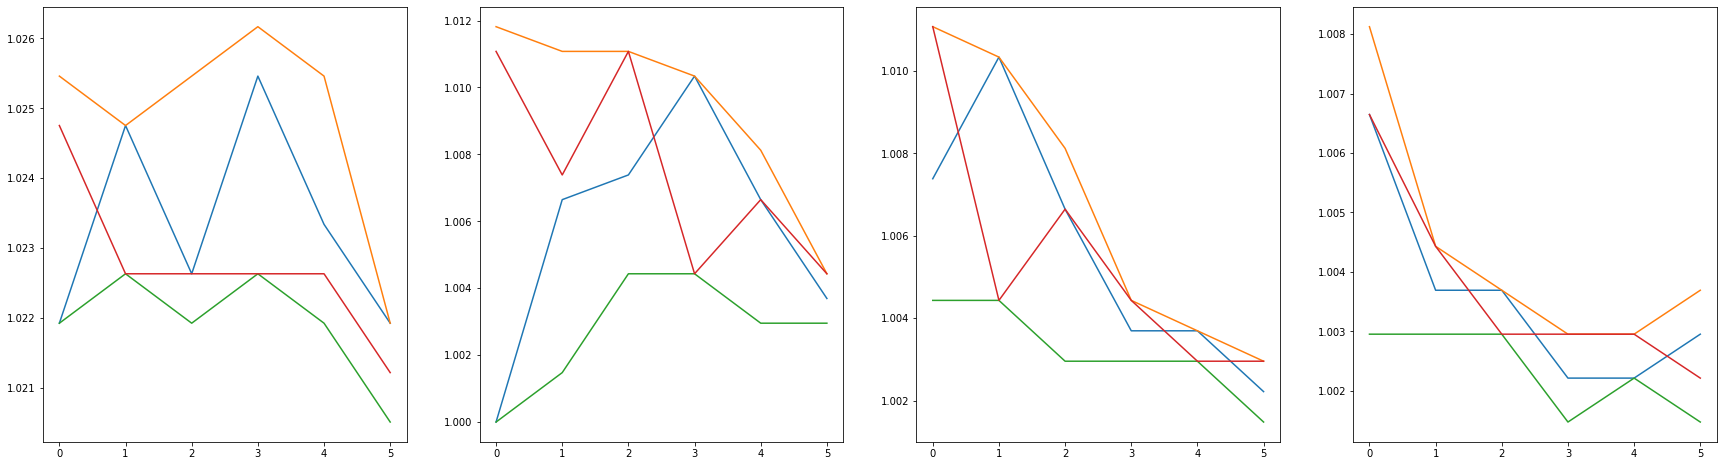

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.hist(np.array(kosdaq1_bps))
plt.figure(figsize=(30,8))
plt.subplot(1,4,1)
plt.plot(np.array(kosdaq1_data[10])[:,:4])
plt.subplot(1,4,2)
plt.plot(np.array(kosdaq1_data[11])[:,:4])
plt.subplot(1,4,3)
plt.plot(np.array(kosdaq1_data[12])[:,:4])
plt.subplot(1,4,4)
plt.plot(np.array(kosdaq1_data[13])[:,:4])

In [ ]:
kosdaq_bps = np.concatenate((kosdaq1_bps, kosdaq2_bps), axis=0)
kosdaq_labels = np.concatenate((kosdaq1_lables, kosdaq2_labels), axis=0)
kosdaq_data = np.concatenate((kosdaq1_data, kosdaq2_data), axis=0)

In [30]:
sum(np.array(kosdaq1_lables)==0),sum(np.array(kosdaq1_lables)==1),sum(np.array(kosdaq1_lables)==2),sum(np.array(kosdaq1_lables)==3)

(98750, 90236, 90273, 2568)

In [ ]:
sum(np.array(kosdaq2_labels)==0),sum(np.array(kosdaq2_labels)==1)#,sum(np.array(kosdaq2_labels)==2)

(1331, 1178)

In [ ]:
sum(kosdaq1_lables) / kosdaq1_lables.__len__(), sum(kosdaq2_labels) / kosdaq2_labels.__len__() #49374795

(0.47010309278350515, 0.46950976484655244)

In [ ]:
chosen_x=np.load('/content/drive/MyDrive/캡스톤디자인프로젝트/x_data.npy')
chosen_label=np.load('/content/drive/MyDrive/캡스톤디자인프로젝트/labels_0.003_6.npy')
print(chosen_x.shape)
print(chosen_label.shape)

(3838516, 6, 8)
(3838516,)


In [ ]:
chosen_x=np.transpose(chosen_x,(0,2,1))
print(chosen_x.shape)

(13513, 8, 6)


In [ ]:
from sklearn.model_selection import train_test_split
whole_ind = np.arange(chosen_x.shape[0])
train_ind, val_ind, train_labels, val_labels = train_test_split(whole_ind, chosen_label, test_size=0.1, random_state = 42, stratify=chosen_label)
train_ind, test_ind, train_labels, test_labels = train_test_split(train_ind, train_labels, test_size=0.1, random_state = 42, stratify=train_labels)

In [31]:
from sklearn.model_selection import train_test_split
whole_ind = np.arange(kosdaq1_data.shape[0])
train_ind, val_ind, train_labels, val_labels = train_test_split(whole_ind, kosdaq1_lables, test_size=0.1, random_state = 42)
train_ind, test_ind, train_labels, test_labels = train_test_split(train_ind, train_labels, test_size=0.1, random_state = 42)

In [ ]:
val_labels.shape

(1352,)

In [32]:
train = kosdaq1_data[train_ind]
val = kosdaq1_data[val_ind]
test = kosdaq1_data[test_ind]

In [ ]:
train = chosen_x[train_ind]
val = chosen_x[val_ind]
test = chosen_x[test_ind]

In [33]:
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_data_09011000_3000_05_finetunnin_1107.npy', train)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_data_09011000_3000_05_finetunnin_1107.npy', val)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_data_09011000_3000_05_finetunnin_1107.npy', test)

np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_labels_09011000_3000_05_finetunnin_1107.npy', train_labels)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_labels_09011000_3000_05_finetunnin_1107.npy', val_labels)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_labels_09011000_3000_05_finetunnin_1107.npy', test_labels)

In [ ]:
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_data_0003.npy', train)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_data_0003.npy', val)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_data_0003.npy', test)

np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_labels_0003.npy', train_labels)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_labels_0003.npy', val_labels)
np.save('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_labels_chosen.npy', test_labels)